In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras

print(tf.__version__)

1.14.0


## 1. Data Exploration: Inspecting the MNIST Dataset

In [2]:
# Importing the MNIST dataset from keras
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
# Inspecting shapes
print('X Train: {}'.format(x_train.shape))
print('X Test:  {}'.format(x_test.shape))
print('Y Train: {}'.format(y_train.shape))
print('X Test:  {}'.format(y_test.shape))

X Train: (60000, 28, 28)
X Test:  (10000, 28, 28)
Y Train: (60000,)
X Test:  (10000,)


In [4]:
# Inspecting min and max
print('X Train min {} max {}'.format(x_train.min(), x_train.max()))
print('X Test  min {} max {}'.format(x_test.min(), x_test.max()))
print('Y Train min {} max {}'.format(y_train.min(), y_train.max()))
print('Y Test  min {} max {}'.format(y_test.min(), y_test.max()))

X Train min 0 max 255
X Test  min 0 max 255
Y Train min 0 max 9
Y Test  min 0 max 9


In [5]:
# Inspecting class label distribution/skewness
import numpy as np
import pandas as pd

print('NumPy', np.__version__)
print('Pandas', pd.__version__)

classes, counts = np.unique(y_train, return_counts=True)
class_fd_train = dict(zip(classes, counts * 100 / y_train.shape[0]))
classes, counts = np.unique(y_test, return_counts=True)
class_fd_test = dict(zip(classes, counts * 100 / y_test.shape[0]))

if class_fd_test.keys() == class_fd_train.keys():
    print('\nAll classes present in both: True', end='\n\n')
    class_dist = {'train': [], 'test': []}
    classes.sort()
    for class_label in classes:
        class_dist['train'].append(class_fd_train[class_label])
        class_dist['test'].append(class_fd_test[class_label])
    class_dist = pd.DataFrame(class_dist, index=classes)
    print(class_dist)
else:
    print('All classes present in both: False')

NumPy 1.17.2
Pandas 0.23.4

All classes present in both: True

       train   test
0   9.871667   9.80
1  11.236667  11.35
2   9.930000  10.32
3  10.218333  10.10
4   9.736667   9.82
5   9.035000   8.92
6   9.863333   9.58
7  10.441667  10.28
8   9.751667   9.74
9   9.915000  10.09


3.0.2


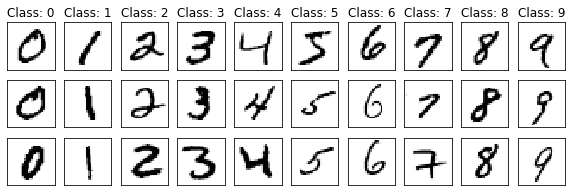

In [6]:
# Showing sample x_train images
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print(matplotlib.__version__)

n_rows = 3
fig, axs = plt.subplots(nrows=n_rows,
                        ncols=len(classes), figsize=[10, n_rows])

for col, class_label in enumerate(classes):
    sample = np.where(y_train == class_label)[0]
    for row in range(n_rows):
        axs[row, col].imshow(x_train[sample[row]], cmap=plt.cm.Greys)
        axs[row, col].axes.get_xaxis().set_visible(False)
        axs[row, col].axes.get_yaxis().set_visible(False)
        if row == 0:  # Show label on the title for first row only
            axs[row, col].set_title('Class: {}'.format(class_label))

plt.show()

### Data Exploration Conlusions:
1. 60k training and 10k testing samples
2. X samples are 28x28 binary images of handwritten numbers
3. Y samples are the labels for the handrwitten numbers and range between 0 to 9
4. 784 numerical features ranging between 0 and 255
5. 10 classes (0 through 9) that are equally distributed 
6. Multi-Class Classification Problem

## 2. Preprocessing: Scaling
Neural Networks accuracy is significantly improved when the input features are scaled. There are primarily two methods for scaling numerical data:
* **Normalization**: scaling between 0 and 1
* **Standardization**: scaling to obtain mean of 0 and standard deviation of 1

We will be normalizing our data.

In [8]:
# Normalizing feature sets
x_train_scaled = tf.keras.utils.normalize(x_train, axis=1)
x_test_scaled = tf.keras.utils.normalize(x_test, axis=1)

# Inspecting min and max
print('X Train min {} max {}'.format(x_train_scaled.min(),
                                     x_train_scaled.max()))
print('X Test  min {} max {}'.format(x_test_scaled.min(),
                                     x_test_scaled.max()))

X Train min 0.0 max 1.0
X Test  min 0.0 max 1.0
